The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
!pip install -U mxnet-cu101==1.7.0


# 实战 Kaggle 比赛：图像分类 (CIFAR-10)
:label:`sec_kaggle_cifar10`

之前几节中，我们一直在使用深度学习框架的高级API直接获取张量格式的图像数据集。
但是在实践中，图像数据集通常以图像文件的形式出现。
本节将从原始图像文件开始，然后逐步组织、读取并将它们转换为张量格式。

我们在 :numref:`sec_image_augmentation`中对CIFAR-10数据集做了一个实验。CIFAR-10是计算机视觉领域中的一个重要的数据集。
本节将运用我们在前几节中学到的知识来参加CIFAR-10图像分类问题的Kaggle竞赛，(**比赛的网址是https://www.kaggle.com/c/cifar-10**)。

 :numref:`fig_kaggle_cifar10`显示了竞赛网站页面上的信息。
为了能提交结果，首先需要注册一个Kaggle账户。

![CIFAR-10 图像分类竞赛页面上的信息。竞赛用的数据集可通过点击“Data”选项卡获取。](../img/kaggle-cifar10.png)
:width:`600px`
:label:`fig_kaggle_cifar10`

首先，导入竞赛所需的包和模块。


In [1]:
import collections
import math
import os
import shutil
import pandas as pd
from mxnet import gluon, init, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## 获取并组织数据集

比赛数据集分为训练集和测试集，其中训练集包含50000张、测试集包含300000张图像。
在测试集中，10000张图像将被用于评估，而剩下的290000张图像将不会被进行评估，包含它们只是为了防止手动标记测试集并提交标记结果。
两个数据集中的图像都是png格式，高度和宽度均为32像素并有三个颜色通道（RGB）。
这些图片共涵盖10个类别：飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车。
 :numref:`fig_kaggle_cifar10`的左上角显示了数据集中飞机、汽车和鸟类的一些图像。

### 下载数据集

登录Kaggle后，我们可以点击 :numref:`fig_kaggle_cifar10`中显示的CIFAR-10图像分类竞赛网页上的“Data”选项卡，然后单击“Download All”按钮下载数据集。
在`../data`中解压下载的文件并在其中解压缩`train.7z`和`test.7z`后，在以下路径中可以找到整个数据集：

* `../data/cifar-10/train/[1-50000].png`
* `../data/cifar-10/test/[1-300000].png`
* `../data/cifar-10/trainLabels.csv`
* `../data/cifar-10/sampleSubmission.csv`

`train`和`test`文件夹分别包含训练和测试图像，`trainLabels.csv`含有训练图像的标签，
`sample_submission.csv`是提交文件的范例。

为了便于入门，[**我们提供包含前1000个训练图像和5个随机测试图像的数据集的小规模样本**]。
要使用Kaggle竞赛的完整数据集，需要将以下`demo`变量设置为`False`。


In [2]:
#@save
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果使用完整的Kaggle竞赛的数据集，设置demo为False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

### [**整理数据集**]

我们需要整理数据集来训练和测试模型。
首先，我们用以下函数读取CSV文件中的标签，它返回一个字典，该字典将文件名中不带扩展名的部分映射到其标签。


In [3]:
#@save
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练样本 : 1000
# 类别 : 10


接下来，我们定义`reorg_train_valid`函数来[**将验证集从原始的训练集中拆分出来**]。
此函数中的参数`valid_ratio`是验证集中的样本数与原始训练集中的样本数之比。
更具体地说，令$n$等于样本最少的类别中的图像数量，而$r$是比率。
验证集将为每个类别拆分出$\max(\lfloor nr\rfloor,1)$张图像。
让我们以`valid_ratio=0.1`为例，由于原始的训练集有50000张图像，因此`train_valid_test/train`路径中将有45000张图像用于训练，而剩下5000张图像将作为路径`train_valid_test/valid`中的验证集。
组织数据集后，同类别的图像将被放置在同一文件夹下。


In [4]:
#@save
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

#@save
def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

下面的`reorg_test`函数用来[**在预测期间整理测试集，以方便读取**]。


In [5]:
#@save
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

最后，我们使用一个函数来[**调用前面定义的函数**]`read_csv_labels`、`reorg_train_valid`和`reorg_test`。


In [6]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

在这里，我们只将样本数据集的批量大小设置为32。
在实际训练和测试中，应该使用Kaggle竞赛的完整数据集，并将`batch_size`设置为更大的整数，例如128。
我们将10％的训练样本作为调整超参数的验证集。


In [7]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

## [**图像增广**]

我们使用图像增广来解决过拟合的问题。例如在训练中，我们可以随机水平翻转图像。
我们还可以对彩色图像的三个RGB通道执行标准化。
下面，我们列出了其中一些可以调整的操作。


In [8]:
transform_train = gluon.data.vision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    gluon.data.vision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    gluon.data.vision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor(),
    # 标准化图像的每个通道
    gluon.data.vision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                           [0.2023, 0.1994, 0.2010])])

在测试期间，我们只对图像执行标准化，以消除评估结果中的随机性。


In [9]:
transform_test = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                           [0.2023, 0.1994, 0.2010])])

## 读取数据集

接下来，我们[**读取由原始图像组成的数据集**]，每个样本都包括一张图片和一个标签。


In [10]:
train_ds, valid_ds, train_valid_ds, test_ds = [
    gluon.data.vision.ImageFolderDataset(
        os.path.join(data_dir, 'train_valid_test', folder))
    for folder in ['train', 'valid', 'train_valid', 'test']]

在训练期间，我们需要[**指定上面定义的所有图像增广操作**]。
当验证集在超参数调整过程中用于模型评估时，不应引入图像增广的随机性。
在最终预测之前，我们根据训练集和验证集组合而成的训练模型进行训练，以充分利用所有标记的数据。


In [11]:
train_iter, train_valid_iter = [gluon.data.DataLoader(
    dataset.transform_first(transform_train), batch_size, shuffle=True,
    last_batch='discard') for dataset in (train_ds, train_valid_ds)]

valid_iter = gluon.data.DataLoader(
    valid_ds.transform_first(transform_test), batch_size, shuffle=False,
    last_batch='discard')

test_iter = gluon.data.DataLoader(
    test_ds.transform_first(transform_test), batch_size, shuffle=False,
    last_batch='keep')

## 定义[**模型**]


在这里，我们基于`HybridBlock`类构建剩余块，这与 :numref:`sec_resnet`中描述的实现方法略有不同，是为了提高计算效率。


In [12]:
class Residual(nn.HybridBlock):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1,
                               strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1,
                                   strides=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def hybrid_forward(self, F, X):
        Y = F.npx.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.npx.relu(Y + X)

接下来，我们定义Resnet-18模型。


In [13]:
def resnet18(num_classes):
    net = nn.HybridSequential()
    net.add(nn.Conv2D(64, kernel_size=3, strides=1, padding=1),
            nn.BatchNorm(), nn.Activation('relu'))

    def resnet_block(num_channels, num_residuals, first_block=False):
        blk = nn.HybridSequential()
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.add(Residual(num_channels))
        return blk

    net.add(resnet_block(64, 2, first_block=True),
            resnet_block(128, 2),
            resnet_block(256, 2),
            resnet_block(512, 2))
    net.add(nn.GlobalAvgPool2D(), nn.Dense(num_classes))
    return net

在训练开始之前，我们使用 :numref:`subsec_xavier`中描述的Xavier初始化。


In [14]:
def get_net(devices):
    num_classes = 10
    net = resnet18(num_classes)
    net.initialize(ctx=devices, init=init.Xavier())
    return net

loss = gluon.loss.SoftmaxCrossEntropyLoss()

## 定义[**训练函数**]

我们将根据模型在验证集上的表现来选择模型并调整超参数。
下面我们定义了模型训练函数`train`。


In [15]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(
                net, features, labels.astype('float32'), loss, trainer,
                devices, d2l.split_batch)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpus(net, valid_iter,
                                                   d2l.split_batch)
            animator.add(epoch + 1, (None, None, valid_acc))
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

## [**训练和验证模型**]

现在，我们可以训练和验证模型了，而以下所有超参数都可以调整。
例如，我们可以增加周期的数量。当`lr_period`和`lr_decay`分别设置为4和0.9时，优化算法的学习速率将在每4个周期乘以0.9。
为便于演示，我们在这里只训练20个周期。


train loss 0.735, train acc 0.747, valid acc 0.359
807.5 examples/sec on [gpu(0), gpu(1)]


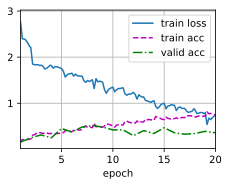

In [16]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 0.02, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net(devices)
net.hybridize()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## 在 Kaggle 上[**对测试集进行分类并提交结果**]

在获得具有超参数的满意的模型后，我们使用所有标记的数据（包括验证集）来重新训练模型并对测试集进行分类。


train loss 0.759, train acc 0.731
1076.7 examples/sec on [gpu(0), gpu(1)]


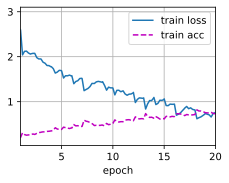

In [17]:
net, preds = get_net(devices), []
net.hybridize()
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.as_in_ctx(devices[0]))
    preds.extend(y_hat.argmax(axis=1).astype(int).asnumpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])
df.to_csv('submission.csv', index=False)

向Kaggle提交结果的方法与 :numref:`sec_kaggle_house`中的方法类似，上面的代码将生成一个
`submission.csv`文件，其格式符合Kaggle竞赛的要求。

## 小结

* 将包含原始图像文件的数据集组织为所需格式后，我们可以读取它们。


* 我们可以在图像分类竞赛中使用卷积神经网络、图像增广和混合编程。


## 练习

1. 在这场Kaggle竞赛中使用完整的CIFAR-10数据集。将超参数设为`batch_size = 128`，`num_epochs = 100`，`lr = 0.1`，`lr_period = 50`，`lr_decay = 0.1`。看看在这场比赛中能达到什么准确度和排名。能进一步改进吗？
1. 不使用图像增广时，能获得怎样的准确度？


[Discussions](https://discuss.d2l.ai/t/2830)
